# from url

Using device: cuda
Loading curr images...


100%|██████████| 6/6 [00:00<00:00, 864.89it/s]


Loading ref images...


100%|██████████| 6/6 [00:00<00:00, 1847.58it/s]



Generating embeddings for curr dataset...


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00, 10.52it/s]


Generating embeddings for ref dataset...


Generating embeddings: 100%|██████████| 2/2 [00:00<00:00, 76.24it/s]

Curr embeddings shape: (6, 768)
Ref embeddings shape: (6, 768)

--- Numerical Comparison ---
Euclidean distance between mean embeddings (curr vs ref): 32.3576
Average cosine similarity between all pairs (curr vs ref): 0.0437
Average internal Euclidean distance (Curr dataset): 54.0745
Average internal Euclidean distance (Ref dataset): 51.1854

--- Visual Comparison (Dimensionality Reduction) ---
Total embeddings for visualization: 12
Applying PCA...


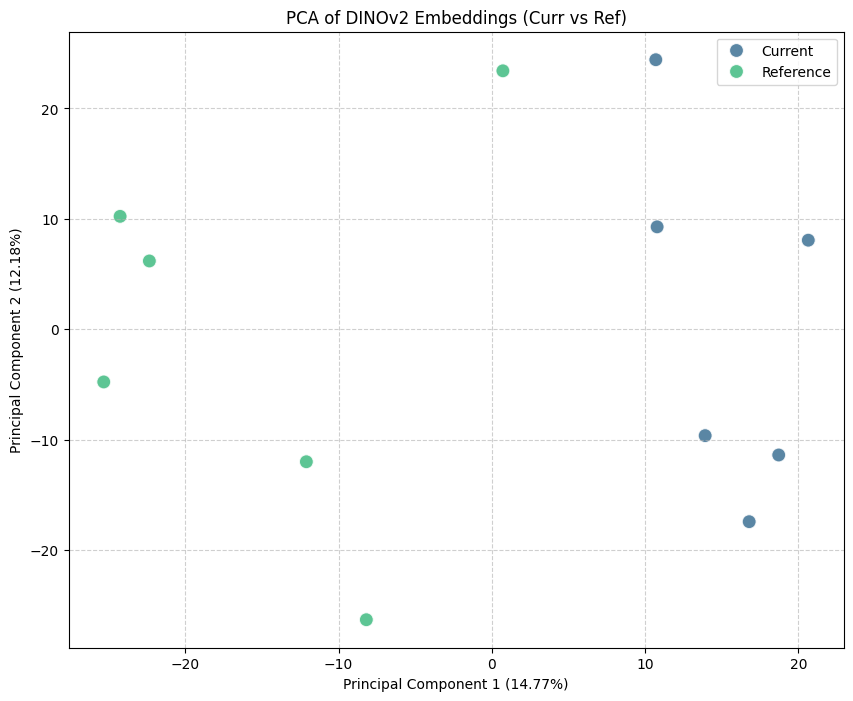

PCA explained variance ratio: [0.14774984 0.12180047]
Applying t-SNE (this might take a while)...


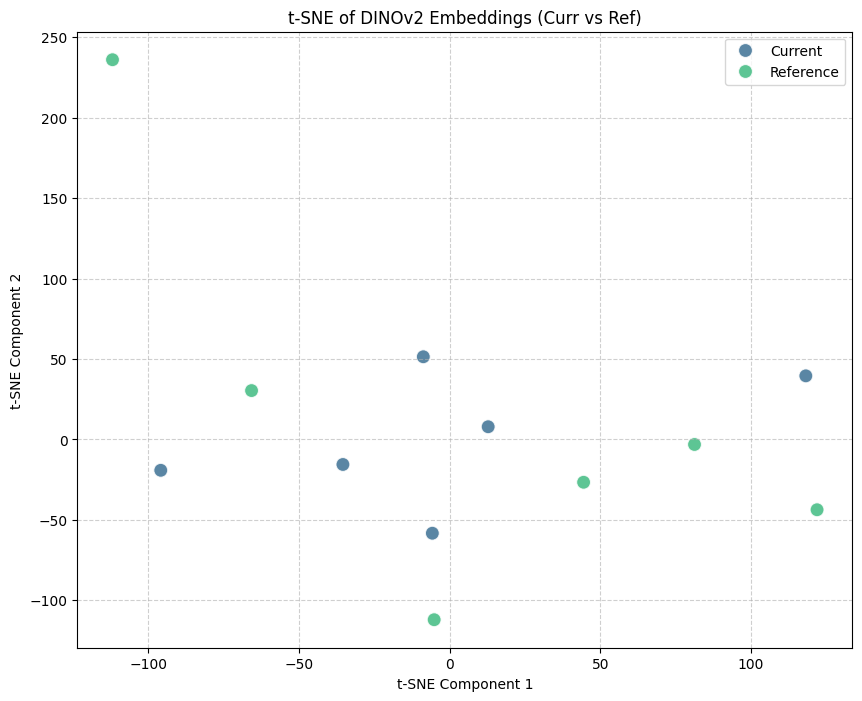

Applying UMAP (typically faster than t-SNE)...


/home/jpark/www/venv_base/lib/python3.10/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/jpark/www/venv_base/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/jpark/www/venv_base/lib/python3.10/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)


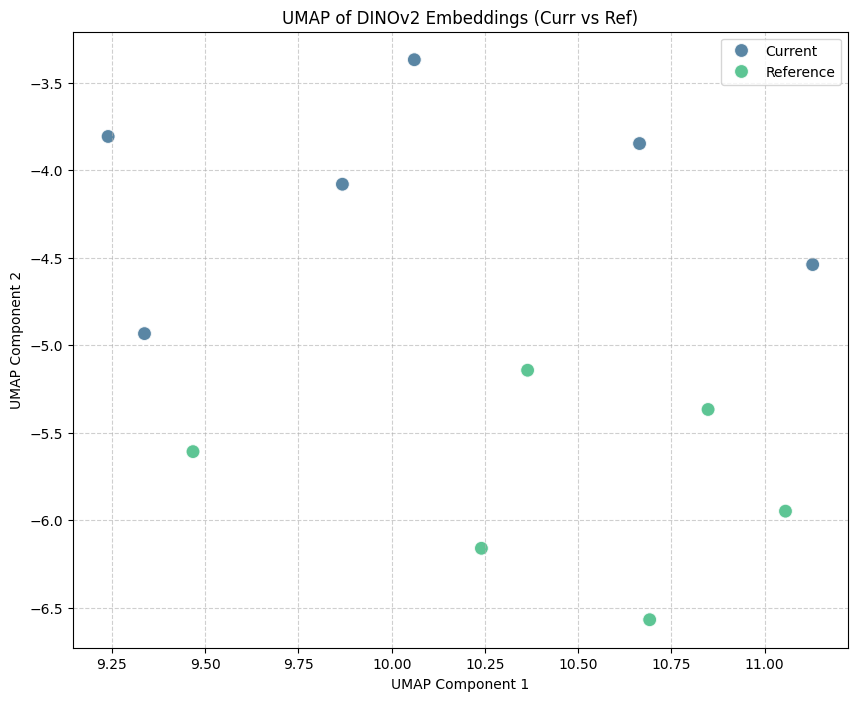


--- Interpretation Guide ---
Numerical Comparison:
- 'Euclidean distance between mean embeddings': 두 데이터셋의 중심이 얼마나 떨어져 있는가 (멀수록 차이 큼).
- 'Average cosine similarity': 두 데이터셋의 모든 이미지 쌍 간의 평균 유사도 (높을수록 유사성 큼).
- 'Average internal Euclidean distance': 각 데이터셋 내부의 이미지들이 얼마나 뭉쳐있는가 (작을수록 응집도 높음).

Visual Comparison:
- PCA: 데이터의 가장 큰 분산을 설명하는 두 축으로 투영. 데이터의 전반적인 분포를 파악하기 용이.
- t-SNE: 고차원 공간의 근접한 데이터 포인트를 저차원에서도 가깝게 유지하려 함. 로컬 구조를 잘 보여줌. 군집 형성 여부 확인.
- UMAP: t-SNE와 유사하나, 계산 효율성이 좋고 전역적인 구조를 더 잘 보존하는 경향이 있음. 클러스터링 및 데이터셋 간의 관계 파악.
각 플롯에서 두 색깔의 점들이 얼마나 겹쳐있는지, 혹은 얼마나 명확히 분리되어 있는지를 통해 두 데이터셋의 유사성/차이를 직관적으로 파악할 수 있습니다.


In [3]:
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import requests
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap
from scipy.spatial.distance import cdist # For numerical comparison

# --- 1. 모델 및 프로세서 로드 ---
# DINOv2 모델 로드 (가장 강력한 버전 중 하나)
model_name = "facebook/dinov2-base" # 또는 "dinov2-large", "dinov2-huge"
processor = AutoImageProcessor.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval() # 평가 모드

# GPU 사용 가능 시 GPU로 모델 이동
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
print(f"Using device: {device}")

# --- 2. 더미 데이터셋 생성 (실제 데이터셋으로 대체 가능) ---
# 예시를 위해 이미지 URL 리스트를 만듭니다. 실제로는 로컬 경로를 사용하세요.
# 'curr' 데이터셋: 개 이미지
curr_image_urls = [
    "./imgs/dog/0.jpg",
    "./imgs/dog/1.jpg",
    "./imgs/dog/2.jpg",
    "./imgs/dog/3.jpg",
    "./imgs/dog/4.jpg",
    "./imgs/dog/5.jpg",
]

# 'ref' 데이터셋: 고양이 이미지
ref_image_urls = [
    "./imgs/cat/0.jpg",
    "./imgs/cat/1.jpg",
    "./imgs/cat/2.jpg",
    "./imgs/cat/3.jpg",
    "./imgs/cat/4.jpg",
    "./imgs/cat/5.jpg",
]

# 이미지 로딩 함수
def load_image_from_url(url):
    try:
        response = requests.get(url, stream=True)
        response.raise_for_status() # HTTP 오류 발생 시 예외 발생
        return Image.open(response.raw).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {url}: {e}")
        return None

# 이미지 로딩 함수 (파일 경로 사용)
def load_image_from_file(file_path):
    try:
        # 파일 존재 여부 확인
        if not os.path.exists(file_path):
            print(f"File not found: {file_path}")
            return None
        return Image.open(file_path).convert("RGB")
    except Exception as e:
        print(f"Error loading image from {file_path}: {e}")
        return None
        
# 모든 이미지 로드 및 유효한 이미지 필터링
print("Loading curr images...")
curr_images = [load_image_from_file(url) for url in tqdm(curr_image_urls)]
curr_images = [img for img in curr_images if img is not None]

print("Loading ref images...")
ref_images = [load_image_from_file(url) for url in tqdm(ref_image_urls)]
ref_images = [img for img in ref_images if img is not None]

if not curr_images or not ref_images:
    raise ValueError("Failed to load images. Please check URLs or local paths.")

# --- 3. 이미지 임베딩 생성 함수 ---
def get_image_embeddings(images, model, processor, device, batch_size=4):
    embeddings = []
    for i in tqdm(range(0, len(images), batch_size), desc="Generating embeddings"):
        batch_images = images[i:i+batch_size]
        inputs = processor(images=batch_images, return_tensors="pt").to(device)
        with torch.no_grad():
            # DINOv2는 last_hidden_state의 마지막 토큰(CLS 토큰)이 전체 이미지의 임베딩을 나타냅니다.
            outputs = model(**inputs)
            # CLS 토큰의 임베딩을 사용 (첫 번째 토큰)
            batch_embeddings = outputs.last_hidden_state[:, 0, :].cpu().numpy()
        embeddings.append(batch_embeddings)
    return np.vstack(embeddings) if embeddings else np.array([])

print("\nGenerating embeddings for curr dataset...")
curr_embeddings = get_image_embeddings(curr_images, model, processor, device)

print("Generating embeddings for ref dataset...")
ref_embeddings = get_image_embeddings(ref_images, model, processor, device)

if curr_embeddings.size == 0 or ref_embeddings.size == 0:
    raise ValueError("No embeddings generated. Check image loading and model output.")

print(f"Curr embeddings shape: {curr_embeddings.shape}")
print(f"Ref embeddings shape: {ref_embeddings.shape}")

# --- 4. 수치적 유사성/차이점 비교 ---

# 4.1. 평균 임베딩 벡터 간의 유클리드 거리
mean_curr_embedding = np.mean(curr_embeddings, axis=0)
mean_ref_embedding = np.mean(ref_embeddings, axis=0)

distance_between_means = np.linalg.norm(mean_curr_embedding - mean_ref_embedding)
print(f"\n--- Numerical Comparison ---")
print(f"Euclidean distance between mean embeddings (curr vs ref): {distance_between_means:.4f}")

# 4.2. 데이터셋 간의 평균 코사인 유사도
# 모든 curr 임베딩과 모든 ref 임베딩 쌍 간의 코사인 유사도를 계산
# cdist with metric='cosine' returns 1 - cosine_similarity
cosine_distances = cdist(curr_embeddings, ref_embeddings, metric='cosine')
average_cosine_similarity = 1 - np.mean(cosine_distances)
print(f"Average cosine similarity between all pairs (curr vs ref): {average_cosine_similarity:.4f}")

# 4.3. 데이터셋 내 분산 (Cohesion) - 각 데이터셋이 얼마나 뭉쳐있는가
# 각 데이터셋의 임베딩들 간의 평균 유클리드 거리 (응집도)
dist_curr_internal = cdist(curr_embeddings, curr_embeddings, metric='euclidean')
np.fill_diagonal(dist_curr_internal, 0) # 자기 자신과의 거리는 0으로 처리
mean_dist_curr_internal = np.mean(dist_curr_internal)
print(f"Average internal Euclidean distance (Curr dataset): {mean_dist_curr_internal:.4f}")

dist_ref_internal = cdist(ref_embeddings, ref_embeddings, metric='euclidean')
np.fill_diagonal(dist_ref_internal, 0)
mean_dist_ref_internal = np.mean(dist_ref_internal)
print(f"Average internal Euclidean distance (Ref dataset): {mean_dist_ref_internal:.4f}")


# --- 5. 시각적 비교 (차원 축소) ---
# 모든 임베딩을 합치고 레이블 부여
all_embeddings = np.vstack((curr_embeddings, ref_embeddings))
labels = ['Current'] * len(curr_embeddings) + ['Reference'] * len(ref_embeddings)

print(f"\n--- Visual Comparison (Dimensionality Reduction) ---")
print(f"Total embeddings for visualization: {all_embeddings.shape[0]}")

# 5.1. PCA (Principal Component Analysis)
print("Applying PCA...")
pca = PCA(n_components=2)
reduced_pca = pca.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_pca[:, 0], y=reduced_pca[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)
plt.title('PCA of DINOv2 Embeddings (Curr vs Ref)')
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}%)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}%)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()
print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")


# 5.2. t-SNE (t-Distributed Stochastic Neighbor Embedding)
# 대규모 데이터셋에서는 느릴 수 있으므로, 데이터셋이 클 경우 샘플링 고려
print("Applying t-SNE (this might take a while)...")
tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(all_embeddings) - 1)) # perplexity 조정
reduced_tsne = tsne.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_tsne[:, 0], y=reduced_tsne[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)
plt.title('t-SNE of DINOv2 Embeddings (Curr vs Ref)')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

# 5.3. UMAP (Uniform Manifold Approximation and Projection)
# t-SNE보다 빠르고, 대규모 데이터셋에 더 적합하며, 전역 구조를 잘 보존하는 경향이 있음
print("Applying UMAP (typically faster than t-SNE)...")
reducer = umap.UMAP(random_state=42, n_neighbors=min(15, len(all_embeddings) - 1)) # n_neighbors 조정
reduced_umap = reducer.fit_transform(all_embeddings)

plt.figure(figsize=(10, 8))
sns.scatterplot(x=reduced_umap[:, 0], y=reduced_umap[:, 1], hue=labels, palette='viridis', s=100, alpha=0.8)
plt.title('UMAP of DINOv2 Embeddings (Curr vs Ref)')
plt.xlabel('UMAP Component 1')
plt.ylabel('UMAP Component 2')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

print("\n--- Interpretation Guide ---")
print("Numerical Comparison:")
print("- 'Euclidean distance between mean embeddings': 두 데이터셋의 중심이 얼마나 떨어져 있는가 (멀수록 차이 큼).")
print("- 'Average cosine similarity': 두 데이터셋의 모든 이미지 쌍 간의 평균 유사도 (높을수록 유사성 큼).")
print("- 'Average internal Euclidean distance': 각 데이터셋 내부의 이미지들이 얼마나 뭉쳐있는가 (작을수록 응집도 높음).")

print("\nVisual Comparison:")
print("- PCA: 데이터의 가장 큰 분산을 설명하는 두 축으로 투영. 데이터의 전반적인 분포를 파악하기 용이.")
print("- t-SNE: 고차원 공간의 근접한 데이터 포인트를 저차원에서도 가깝게 유지하려 함. 로컬 구조를 잘 보여줌. 군집 형성 여부 확인.")
print("- UMAP: t-SNE와 유사하나, 계산 효율성이 좋고 전역적인 구조를 더 잘 보존하는 경향이 있음. 클러스터링 및 데이터셋 간의 관계 파악.")
print("각 플롯에서 두 색깔의 점들이 얼마나 겹쳐있는지, 혹은 얼마나 명확히 분리되어 있는지를 통해 두 데이터셋의 유사성/차이를 직관적으로 파악할 수 있습니다.")